In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from torch import autograd
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.loss import *
from fasterai.models import *
from fastai.torch_imports import *
from pathlib import Path
from itertools import repeat
import tensorboardX
torch.cuda.set_device(1)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True


/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
proj_id = 'bw2color'

D_MODEL_SAVE_PATH = DATA_PATH/(proj_id + '_8212_D.h5')
G_MODEL_SAVE_PATH = DATA_PATH/(proj_id + '_8212_G.h5')
keep_pct=1.0
wd=1e-7
bs = 8
sz = 224
torch.backends.cudnn.benchmark=True

## EDSR Model

##### TODO:  Also try making the loss/output based on "classification" like in Zhang et al.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).
##### TODO:  Try using higher res images (from FloydHub blog?)
##### TODO:  Try perceptual loss again....
##### TODO:  To convert real old photos, could force them to normal grayscale first.
##### TODO:  Add tensorboard graphs

In [4]:
class ImageModifierModel(nn.Module):
    @staticmethod
    def _generate_res_layer(ni: int):
        layers = []
        layers.append(ConvBlock(ni, ni//2, ks=1))
        layers.append(ConvBlock(ni//2, ni))
        return ResSequential(layers)
    
    @staticmethod
    def _generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        cut-=1
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers)
    
    @staticmethod
    def _make_group_layer(ch_in, num_blocks):
        layers = [ConvBlock(ch_in, ch_in*2)]
        layers += [(ImageModifierModel._generate_res_layer(ch_in*2)) for i in range(num_blocks)]
        return nn.Sequential(*layers)
    
        
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
        
    def __init__(self):
        super().__init__() 
        
        self.rn = ImageModifierModel._generate_base_model()
        set_trainable(self.rn, False)
        
        self.color = nn.Sequential(
            ImageModifierModel._make_group_layer(256, 1),
            UpSampleBlock(512, 512, 16),
            ConvBlock(512, 3)
        )
        
        self.out = nn.Sequential(
            ImageModifierModel._make_group_layer(6, 1),
            ConvBlock(12,3, actn=False, bn=False)
        )
        
    def forward(self, orig): 
        x = self.rn(orig)
        x = self.color(x)
        return F.tanh(self.out(torch.cat([orig, x], dim=1)))

## WGAN Critic Model

In [5]:
class Critic2(nn.Module):
    @staticmethod
    def _generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
        
    @staticmethod
    def _generate_eval_layers(nf_in, nf_mid, sz):
        layers = [] 
        layers.append(ConvBlock(nf_in, nf_mid, 4, 2, bn=False))
        csize,cndf = sz//2,nf_mid
        layers.append(nn.LayerNorm([cndf, csize, csize]))
        layers.append(ConvBlock(cndf, cndf, 3, 1, bn=False))
        layers.append(nn.LayerNorm([cndf, csize, csize]))

        while csize > 8:
            layers.append(ConvBlock(cndf, cndf*2, 4, 2, bn=False))
            cndf = int(cndf*2)
            csize = int(csize//2)
            layers.append(nn.LayerNorm([cndf, csize, csize]))
        
        layers.append(nn.Conv2d(cndf, 1, 4, padding=0, bias=False))    
        return nn.Sequential(*layers) 
            
    def __init__(self, sz):
        super().__init__()
         
        rn, lr_cut = Critic2._generate_base_model()
        self.rn = rn
        set_trainable(self.rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.feature_eval_1 = Critic2._generate_eval_layers(256*2, 256, sz//16)
        self.feature_eval_2 = Critic2._generate_eval_layers(128*2, 128, sz//8)
        self.feature_eval_3 = Critic2._generate_eval_layers(64*2, 64, sz//4)
        self.feature_eval_4 = Critic2._generate_eval_layers(64*2, 64, sz//2)     
        self.pixel_eval = Critic2._generate_eval_layers(6, 64, sz)
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.sfs[3].features
        x2 = self.sfs[2].features
        x3 = self.sfs[1].features
        x4 = self.sfs[0].features
        
        self.rn(input)
        y1 = self.sfs[3].features
        y2 = self.sfs[2].features
        y3 = self.sfs[1].features
        y4 = self.sfs[0].features 

        f1 = self.feature_eval_1(torch.cat([x1, y1], dim=1))
        f2 = self.feature_eval_2(torch.cat([x2, y2], dim=1))
        f3 = self.feature_eval_3(torch.cat([x3, y3], dim=1))
        f4 = self.feature_eval_4(torch.cat([x4, y4], dim=1))
  
        p = self.pixel_eval(torch.cat([orig, input], dim=1))
        return f1.mean() + f2.mean() + f3.mean()  + f4.mean() + p.mean()

## Training

In [6]:
netG = ImageModifierModel().cuda()
#load_model(netG, G_MODEL_SAVE_PATH)
netD = Critic2(sz).cuda()
#load_model(netD, D_MODEL_SAVE_PATH)

/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)


In [7]:
#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-4)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-4)

#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-3)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-3)

#TODO:  Weird beta 1 value, but we'll see...

optimizerD = optim.Adam(filter(lambda p: p.requires_grad,netD.parameters()), lr=1e-5, betas=(0., 0.9))
optimizerG = optim.Adam(filter(lambda p: p.requires_grad,netG.parameters()), lr=1e-5, betas=(0., 0.9))

In [8]:
def calc_gradient_penalty(netD, real_data, fake_data, orig_data):
    lamda = 10 # Gradient penalty lambda hyperparameter
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(bs, 1)
    alpha = alpha.expand(bs, real_data.nelement()//bs).contiguous().view(bs, 3, sz, sz)
    alpha = alpha.cuda()
    differences = fake_data - real_data
    interpolates = real_data + (alpha*differences)
    interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates, orig_data)
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamda
    return gradient_penalty

In [9]:
def progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, ecount):
    if i % 50 == 0:
        print(f'\nWDist {to_np(w_dist)}; GPenalty {to_np(gradient_penalty)}; RScore {to_np(disc_real)};'
          + f' FScore {to_np(disc_fake)}; ECount: {ecount}')

    if i % 500 == 0:
        visualize_image_gen_model(md, netG, 500, 8)
        save_model(netD, D_MODEL_SAVE_PATH)
        save_model(netG, G_MODEL_SAVE_PATH)

def is_equilibrium(disc_real, disc_fake):
    if disc_real < disc_fake:
        return False
        
    return abs(disc_real + disc_fake) < (abs(disc_real) + abs(disc_fake))*0.30

def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        n = n-(n%bs)
        with tqdm(total=n) as pbar:
            while i < n:
                netD.set_trainable(True)
                netG.set_trainable(False)
                j = 0
                equilibrium = False
                while (not equilibrium) and (i < n) and j<10000:
                    j += 1; i += 1
                    #or p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    x, y = next(data_iter)
                    orig_image = V(x)
                    real_image = V(y)                        
                    #Higher == Real
                    disc_real = netD(real_image, orig_image)
                    fake_image = netG(orig_image)
                    disc_fake = netD(V(fake_image.data), orig_image)
                    equilibrium = is_equilibrium(disc_real, disc_fake)
                    
                    netD.zero_grad()
                          
                    gradient_penalty = calc_gradient_penalty(netD, real_image.data, fake_image.data, orig_image)              
                    disc_cost = disc_fake - disc_real + gradient_penalty
                    w_dist = disc_fake - disc_real
                    disc_cost.backward()
                    optimizerD.step()
                    pbar.update()
             
                    progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, gen_iterations)

                    
                netD.set_trainable(False)
                netG.set_trainable(True)
                netG.zero_grad()
                
                x, y = next(data_iter)
                orig_image = V(x)
                real_image = V(y)   
                fake_image = netG(orig_image)
                gen_mse_cost = F.mse_loss(fake_image, real_image)
                gen_cost  = -netD(fake_image, orig_image)
                gen_cost .backward()
                optimizerG.step()
                gen_iterations += 1
                
                progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, gen_iterations)

In [10]:
md = get_matched_image_model_data(image_size=sz, batch_size=bs, root_data_path=DATA_PATH, train_root_path=TRAIN_SOURCE_PATH, proj_id=proj_id, keep_pct=keep_pct)

  0%|          | 50/158544 [00:59<49:16:48,  1.12s/it]
WDist -63.744239807128906; GPenalty 1.556318759918213; RScore 29.66326332092285; FScore -34.08097839355469; ECount: 41

WDist -63.744239807128906; GPenalty 1.556318759918213; RScore 29.66326332092285; FScore -34.08097839355469; ECount: 42
  0%|          | 100/158544 [01:56<49:29:47,  1.12s/it]
WDist -95.41509246826172; GPenalty 1.396322250366211; RScore 37.60496520996094; FScore -57.81012725830078; ECount: 91

WDist -95.41509246826172; GPenalty 1.396322250366211; RScore 37.60496520996094; FScore -57.81012725830078; ECount: 92
  0%|          | 150/158544 [02:52<49:29:23,  1.12s/it]
WDist -141.92843627929688; GPenalty 2.286153793334961; RScore 63.298057556152344; FScore -78.63037109375; ECount: 141

WDist -141.92843627929688; GPenalty 2.286153793334961; RScore 63.298057556152344; FScore -78.63037109375; ECount: 142
  0%|          | 200/158544 [03:49<49:29:15,  1.13s/it]
WDist -164.0059814453125; GPenalty 0.9134427309036255; RScore 69

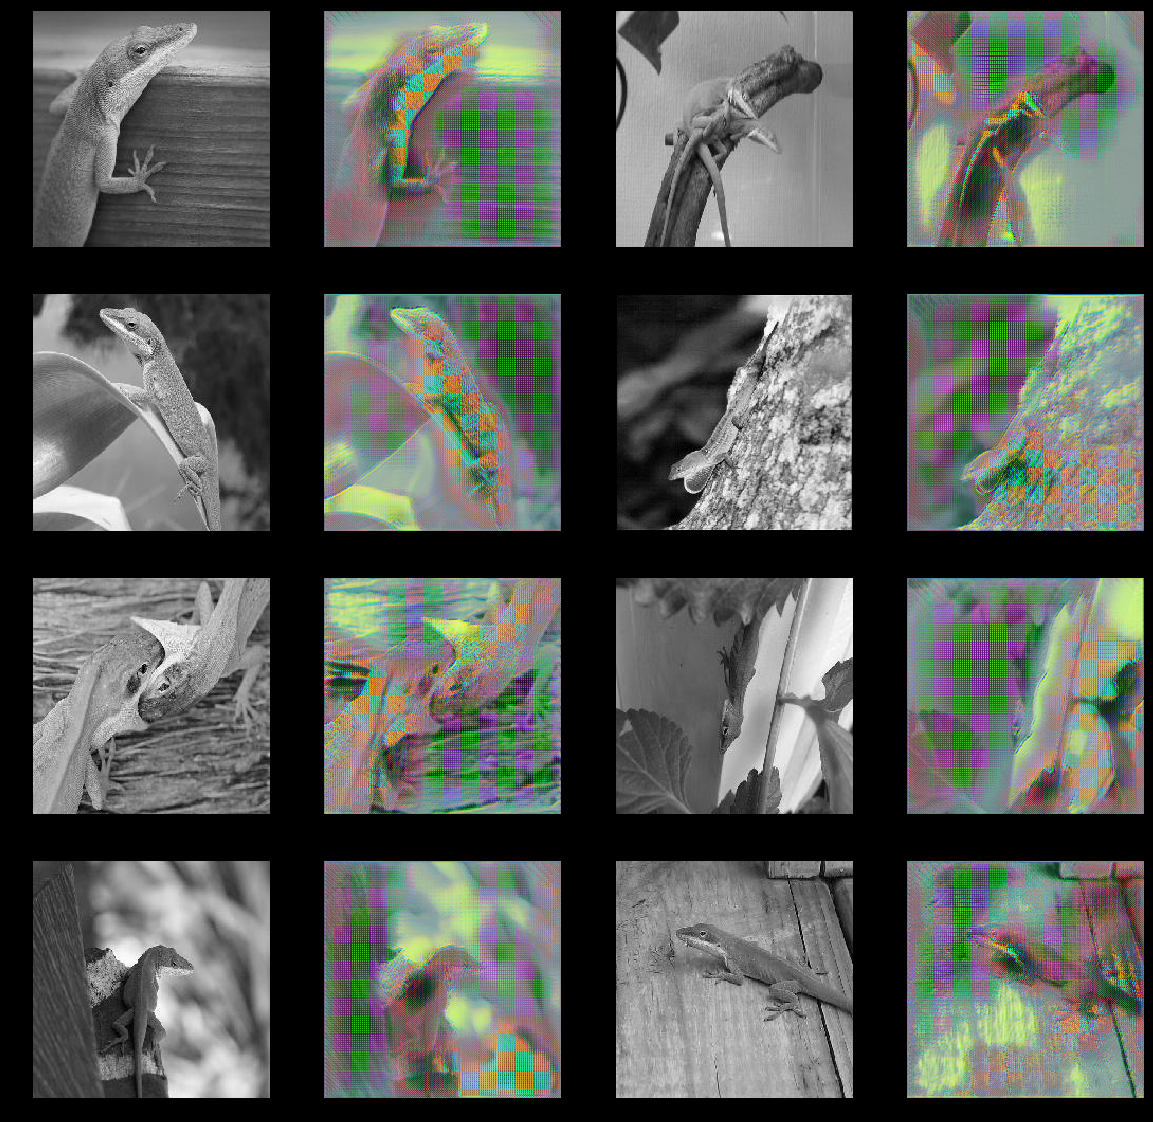


WDist -318.0348815917969; GPenalty 7.707302093505859; RScore 146.67446899414062; FScore -171.36041259765625; ECount: 490


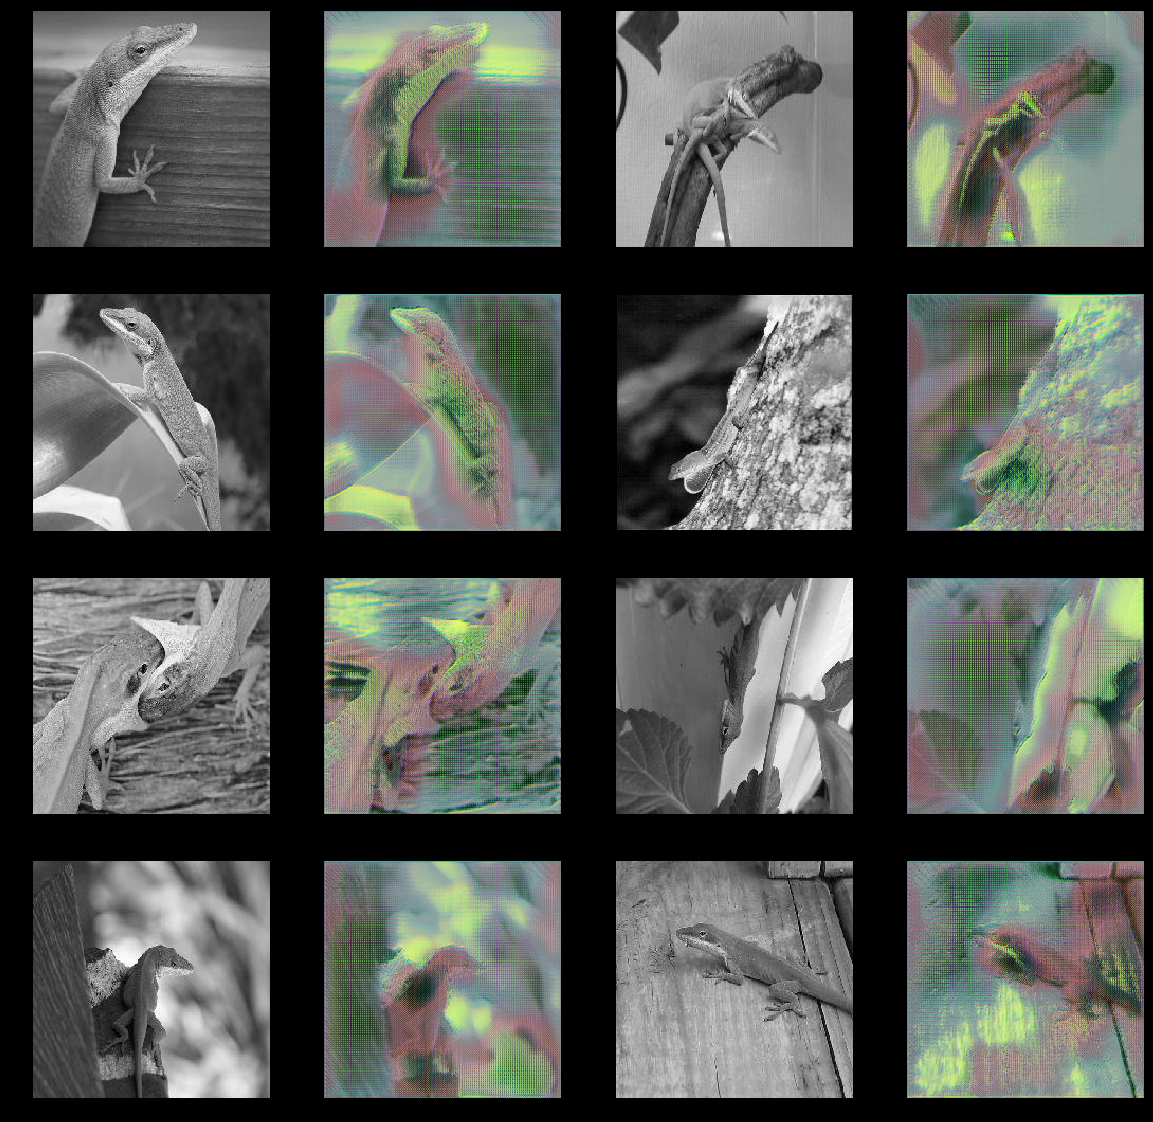

  0%|          | 550/158544 [10:51<49:36:24,  1.13s/it]
WDist -322.1960144042969; GPenalty 8.792784690856934; RScore 176.59149169921875; FScore -145.60452270507812; ECount: 538

WDist -322.1960144042969; GPenalty 8.792784690856934; RScore 176.59149169921875; FScore -145.60452270507812; ECount: 539
  0%|          | 600/158544 [11:50<48:55:47,  1.12s/it]
WDist -374.35150146484375; GPenalty 19.343189239501953; RScore 164.18846130371094; FScore -210.16302490234375; ECount: 587

WDist -374.35150146484375; GPenalty 19.343189239501953; RScore 164.18846130371094; FScore -210.16302490234375; ECount: 588
  0%|          | 650/158544 [12:48<63:46:00,  1.45s/it]
WDist -422.3182373046875; GPenalty 12.951775550842285; RScore 198.02774047851562; FScore -224.29049682617188; ECount: 635

WDist -422.3182373046875; GPenalty 12.951775550842285; RScore 198.02774047851562; FScore -224.29049682617188; ECount: 636
  0%|          | 700/158544 [13:44<49:36:51,  1.13s/it]
WDist -375.384521484375; GPenalty 15.0321

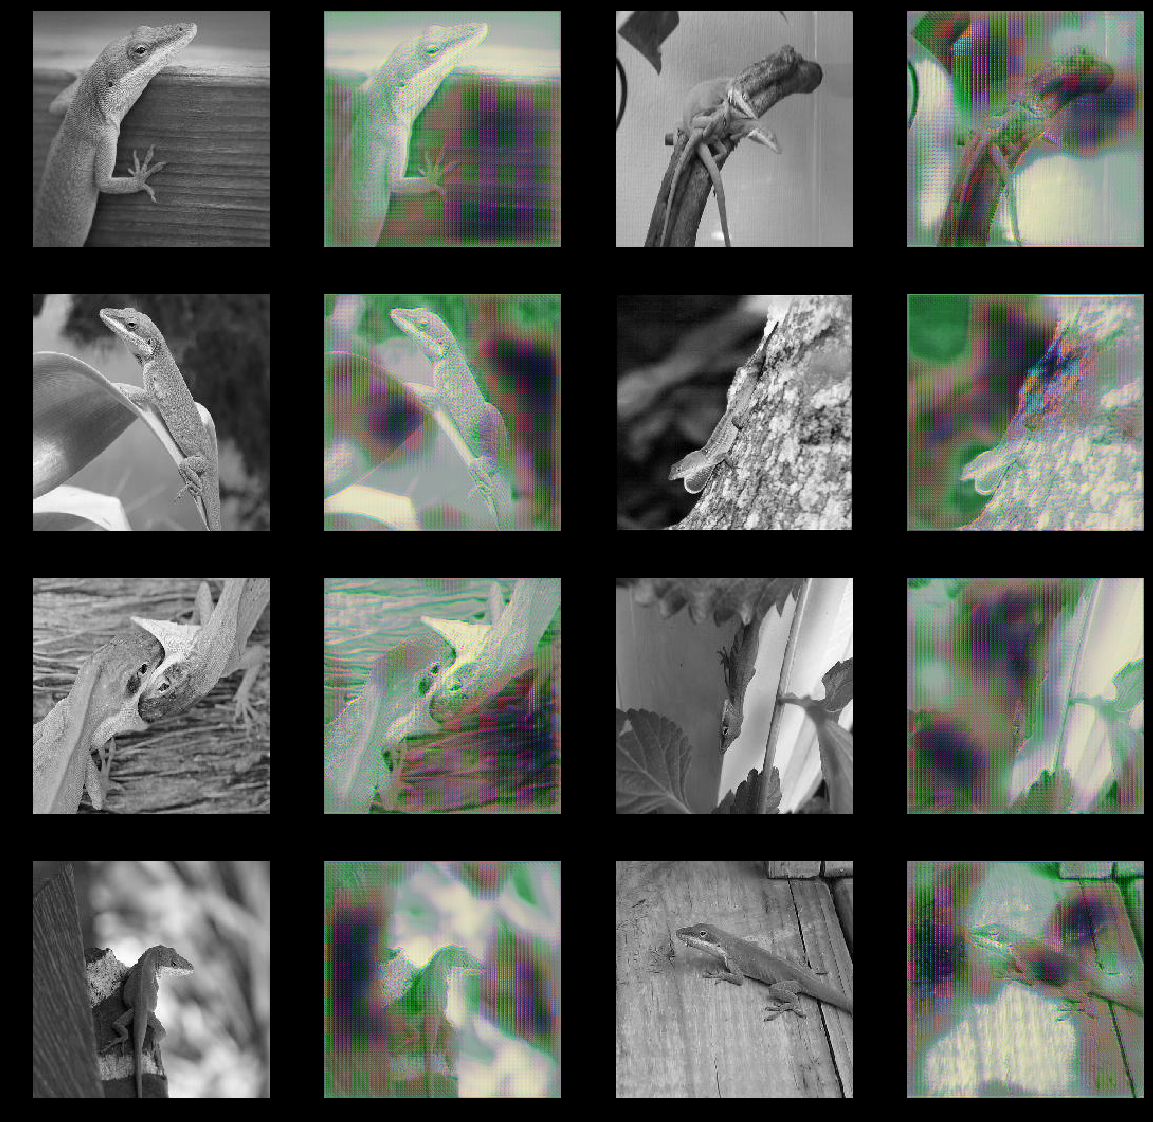


WDist -531.7666625976562; GPenalty 46.532955169677734; RScore 260.0421142578125; FScore -271.72454833984375; ECount: 979


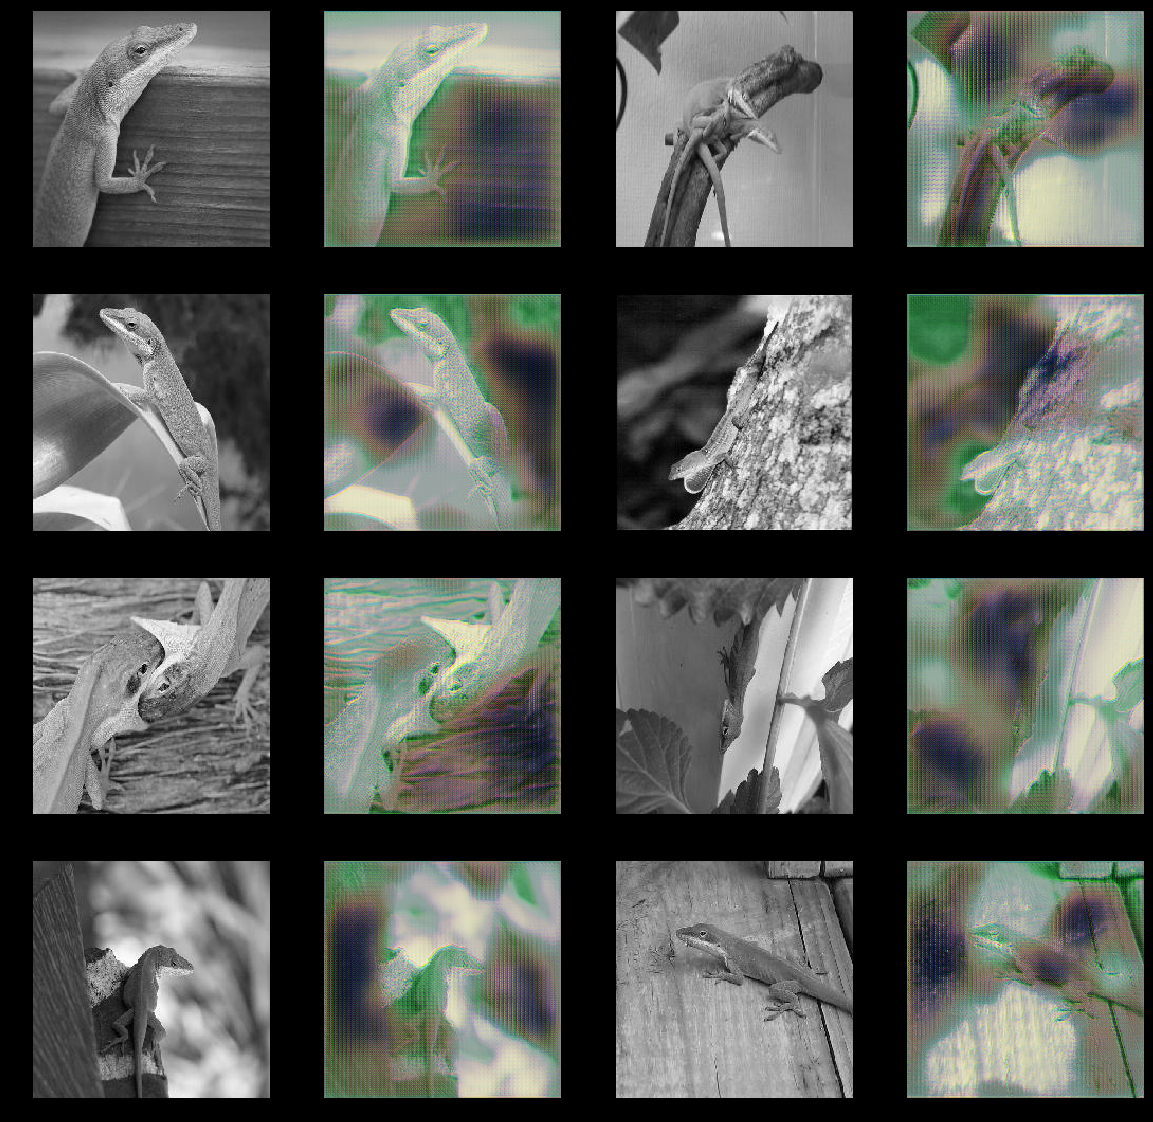

  1%|          | 1050/158544 [23:52<47:27:39,  1.08s/it]
WDist -557.5466918945312; GPenalty 49.976707458496094; RScore 267.2435607910156; FScore -290.3031311035156; ECount: 1023

WDist -557.5466918945312; GPenalty 49.976707458496094; RScore 267.2435607910156; FScore -290.3031311035156; ECount: 1024
  1%|          | 1100/158544 [24:49<49:30:43,  1.13s/it]
WDist -549.3160400390625; GPenalty 98.91021728515625; RScore 252.85238647460938; FScore -296.46368408203125; ECount: 1071

WDist -549.3160400390625; GPenalty 98.91021728515625; RScore 252.85238647460938; FScore -296.46368408203125; ECount: 1072
  1%|          | 1147/158544 [25:44<50:10:28,  1.15s/it]

In [ ]:
train(1, True)
#train(1, False)

In [ ]:
train(9, False)